In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In this week's lesson we were taught about Decision Trees and Random Forests. We learned how both can be effective models for predicting on tabular data, and offer valuable insights into feature importance even when they aren't the most effetive solution. The lecture walked through an example of how to tune a random forest for the *Titanic* dataset.

In this mini-project, I'll tune a random forest for the *Spaceship Titanic* dataset, Kaggle's lesser-known sequel to the *Titanic* dataset.

First, let's check out the dataset:

In [93]:
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [94]:
df.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


Just like in the *Titanic* dataset, we have some numerical columns and some categorical columns. I'll write a *preprocess_df* function we can use to convert these into numeric columns, as well as split inputs and labels. Given PassengerId and Cabin # are in all likelihood useless to split data on, we can just ignore those columns.

In [95]:
def preprocess_df(df, is_test=False, ignore_cols=[]):
    # fill missing values with column modes
    
    inputs = df[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].copy()
    
    modes = inputs.mode().iloc[0]
    inputs.fillna(modes, inplace=True)
    # convert categorical data
    inputs['HomePlanet'] = pd.Categorical(inputs.HomePlanet).codes
    inputs['CryoSleep'] = pd.Categorical(inputs.CryoSleep).codes
    inputs['Destination'] = pd.Categorical(inputs.Destination).codes
    inputs['VIP'] = pd.Categorical(inputs.VIP).codes
    
    if ignore_cols:
        inputs.drop(ignore_cols, inplace=True, axis=1)
    
    labels = None
    
    if not is_test:
        labels = df['Transported']
    
    return inputs, labels
    
    
inputs, labels = preprocess_df(df)

In [96]:
inputs.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0


Next, I split the data into a training and validation set:

In [97]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(inputs, labels, test_size=0.2, random_state=98)

The first model I'll consider is a simple Decision Tree Classifier, which we can use as a baseline. The first thing that might be interesting is a diagram of a simple tree, we can start with 4 leaf nodes and see what the optimal split looks like:

In [98]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_leaf_nodes=4).fit(train_X, train_y)

In [99]:
import graphviz
import re
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

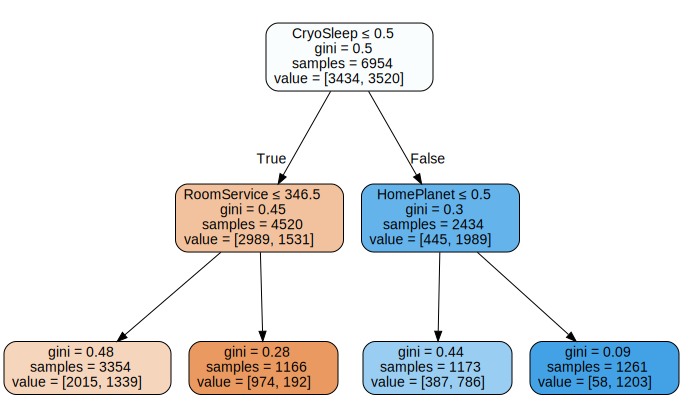

In [100]:
draw_tree(dt, train_X, size=10)

We can see that that splitting by CyroSleep=False and RoomService > 346.5 gives us a population where the majority of samples were transported, while CyroSleep=True and HomePlanet = Earth gives a majority of samples not being transported. 

We can test this simple tree on the validation set:

In [102]:
from sklearn.metrics import accuracy_score

accuracy_score(val_y, dt.predict(val_X))

0.7280046003450259

73% accuracy is not a bad score for such a small tree. Let's see what happens as we increase the number of leaf nodes:

In [103]:
dt = DecisionTreeClassifier(max_leaf_nodes=8).fit(train_X, train_y)
accuracy_score(val_y, dt.predict(val_X))

0.777458309373203

In [104]:
dt = DecisionTreeClassifier(max_leaf_nodes=16).fit(train_X, train_y)
accuracy_score(val_y, dt.predict(val_X))

0.7809085681426107

It looks like increasing the number of leaf nodes (and thus the size of the tree) is beneficial to the model's accuracy. 

Of course, this isn't true indefinitely:

In [105]:
dt = DecisionTreeClassifier(max_leaf_nodes=2048).fit(train_X, train_y)
accuracy_score(val_y, dt.predict(val_X))

0.7487061529614721

We can plot the relationship between number of leaf nodes and validation set accuracy.

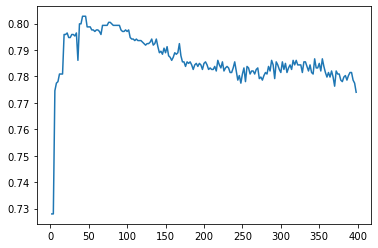

In [106]:
import matplotlib.pyplot as plt

accuracies = []
for i in range(2, 400, 2):
    dt = DecisionTreeClassifier(max_leaf_nodes=i).fit(train_X, train_y)
    accuracies.append((i, accuracy_score(val_y, dt.predict(val_X))))

fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

The plot shows that initially increasing the number of leaf nodes is very helpful to increasing accuracy, but only up to around ~75 leaf nodes before accuracy gradually falls.

We can do a similar test where we limit the *max_depth* of the decision tree:

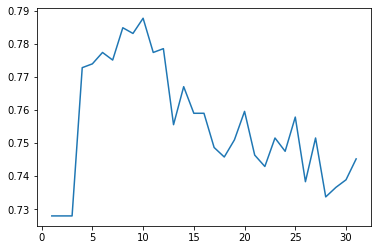

In [107]:
accuracies = []
for i in range(1, 32):
    dt = DecisionTreeClassifier(max_depth=i).fit(train_X, train_y)
    accuracies.append((i, accuracy_score(val_y, dt.predict(val_X))))

fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

Once again, we see that increasing tree size is helpful to a certain point, after which it makes the model less accurate.

The same can be said for *min_samples_split* and *min_samples_leaf*

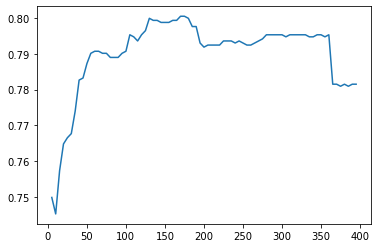

In [108]:
accuracies = []
for i in range(5, 400, 5):
    dt = DecisionTreeClassifier(min_samples_split=i).fit(train_X, train_y)
    accuracies.append((i, accuracy_score(val_y, dt.predict(val_X))))

fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

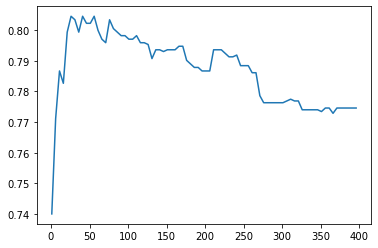

In [109]:
accuracies = []
for i in range(1, 401, 5):
    dt = DecisionTreeClassifier(min_samples_leaf=i).fit(train_X, train_y)
    accuracies.append((i, accuracy_score(val_y, dt.predict(val_X))))

fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

While there are many variables at play, visuals such as these give us good starting points for the tree parameters.

We can test a new decision tree with a collection of the most well-performing hyperparameters to see how it stacks up against our previous tests.

In [110]:
dt = DecisionTreeClassifier(max_leaf_nodes=75, max_depth=10, min_samples_split=150, min_samples_leaf=100).fit(train_X, train_y)
accuracy_score(val_y, dt.predict(val_X))

0.7958596894767107

That's our best validation accuracy yet!

The next improvement we can make is transitioning from one decision trees to an ensembling of many decision trees: a *random forest*. 

Random forests contain many decision trees, trained on differents subsets of the dataset (often called estimators), and average their results. This theory behind this technique is that sampling from many uncorrelated estimators should produce a balaced error distribution across the many estimators. Taking the mean of the errors from each estimator should results in a mean error that is close to 0! (This assumes a balanced distribution of positive and negative errors). Thus adding more estimators, as long as they remain uncorrelated, should result in a smaller error.

In [111]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=75, max_depth=10, min_samples_split=150, min_samples_leaf=100).fit(train_X, train_y)
accuracy_score(val_y, rf.predict(val_X))

0.8021851638872916

One again, our best validation accuracy.

We can plot the relationship between *num_estimators* and validation accuracy:

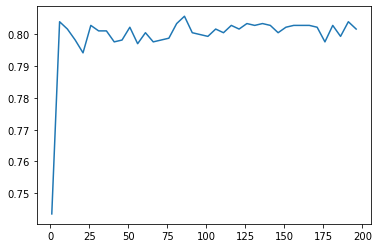

In [112]:
accuracies = []
for i in range(1, 200, 5):
    rf = RandomForestClassifier(n_estimators=i, max_leaf_nodes=75, max_depth=10, min_samples_split=150, min_samples_leaf=100).fit(train_X, train_y)
    accuracies.append((i, accuracy_score(val_y, rf.predict(val_X))))

fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

It's clear that adding more trees is not harmful to the model, like we discussed. We can also test how tree size affects our accuracy again, now that we are using an ensemble approach perhaps things look different. I think it's worth consolidating this down to one metric, so we'll look at *min_samples_leaf*:

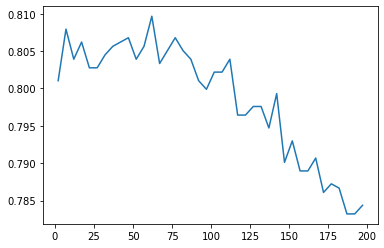

In [113]:
accuracies = []
for i in range(2, 200, 5):
    rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=i).fit(train_X, train_y)
    accuracies.append((i, accuracy_score(val_y, rf.predict(val_X))))

fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

It's clear that we should avoid making this value too high, perhaps a value around ~60 would be best.

We can make our first submission to the kaggle competition to see how we do now!

In [135]:
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

test_inputs, _ = preprocess_df(test_df, is_test=True)

def make_submission(model, inputs, test_df):
    preds = model.predict(inputs)
    test_df['Transported'] = preds.astype(bool)
    sub_df = test_df[['PassengerId', 'Transported']]
    fname = f'submission.csv'
    sub_df.to_csv(fname, index=False)

In [115]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=60).fit(train_X, train_y)

make_submission(rf, test_inputs, test_df)

This model scores 79.4% accuracy on the test set, which puts us right around the 50th percentile of contestants.

Another useful feature of Random Forests is their insights into feature importance. We can collect statistics from each estimator to determine which features the model deems most important to constructing trees. Sklearn has a function for this, *feature_importances_*. We can plot the data:

<AxesSubplot:ylabel='cols'>

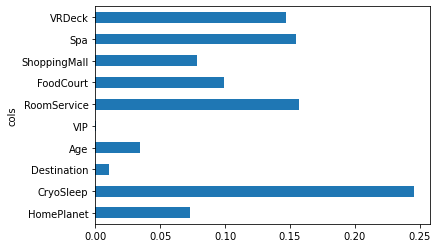

In [116]:
pd.DataFrame(dict(cols=train_X.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh', legend=False)

We see that CryoSleep is clearly the most important feature, followed by the various locaiton spending amounts. We see that VIP, Age, and Destination are all rarely useful. I guess a space-time continuim does not care how *very important* you are.

Let's try removing the 4 most useless columns, VIP, Age, Destination, and HomePlanet

In [117]:
inputs, labels = preprocess_df(df, ignore_cols=['VIP', 'Age', 'Destination', 'HomePlanet'])
train_X, val_X, train_y, val_y = train_test_split(inputs, labels, test_size=0.2, random_state=98)
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=60).fit(train_X, train_y)
accuracy_score(val_y, rf.predict(val_X))



0.8016101207590569

This scores similarly to our current best attempt but not quite as high. We can try another kaggle submission to see how we do:

In [136]:
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test_inputs, _ = preprocess_df(test_df, is_test=True, ignore_cols=['VIP', 'Age', 'Destination', 'HomePlanet'])
make_submission(rf, test_inputs, test_df)

This model scores 79.2% accuracy, slightly lower than we were before. 

One important feature of random forests is they allow for other tuning metrics besides validation accuracy. *Out of Bag Score* measures the prediction error for training samples on estimators not containing that sample, averaged across every sample. This accomplishes about the same thing as testing on a validation set, but it actually means we don't need a validation set at all, meaning our model has more data to train on!

We can use the *oob_score* flag when initializing the model to allow us to view the error.

In [120]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=60, oob_score=True).fit(inputs, labels)
oob_error = 1-rf.oob_score_
oob_error

0.20993903140457837

20.9% error (79.1% accuracy) is our baseline. Let's plot how oob_error changes as we vary *min_samples_leaf*:

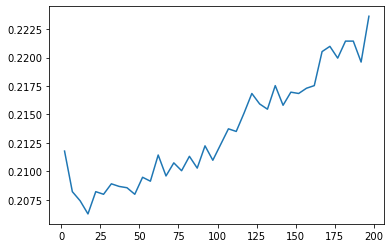

In [121]:
accuracies = []
for i in range(2, 200, 5):
    rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=i, oob_score=True).fit(inputs, labels)
    accuracies.append((i, 1-rf.oob_score_))

fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

We can see that error is minimizied with min_samples_leaf ~20, and gradually increases as we increase the number of samples per leaf. Let's try a new model with min_samples_leaf=20:

In [122]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=20).fit(inputs, labels)
make_submission(rf, test_inputs, test_df)

This gives us our best submission yet with an accuracy of 79.6%! 

We can also take a look at the *max_features* hyperparameter, which constrains the amount of features a single estimator can use:

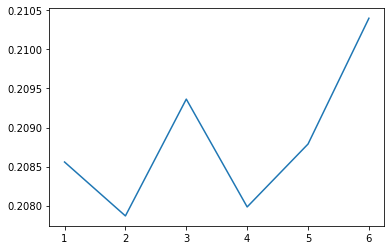

In [123]:
accuracies = []
for i in range(1, 7):
    rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=20, max_features=i, oob_score=True).fit(inputs, labels)
    accuracies.append((i, 1-rf.oob_score_))
    
fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

It looks like using a lower set of estimators can be marginally helpful to reducing error.

We can also take a look at *min_samples_split* rather than *min_samples_leaf* as a different proxy for tree size:

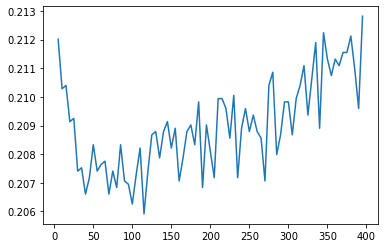

In [124]:
accuracies = []
for i in range(5,400,5):
    rf = RandomForestClassifier(n_estimators=200, min_samples_split=i, oob_score=True).fit(inputs, labels)
    accuracies.append((i, 1-rf.oob_score_))
    
fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

We can see that min_samples_split might best be set around 125, let's try another submission:

In [125]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=125).fit(inputs, labels)
make_submission(rf, test_inputs, test_df)

This once again blows away our previous high score, with 79.9% accuracy! 

We can see if this also holds true when we reduce the number of features considered per tree:

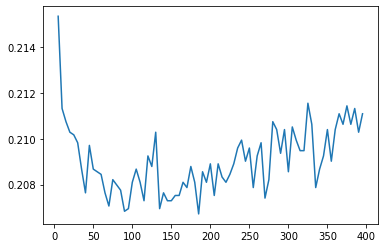

In [126]:
accuracies = []
for i in range(5,400,5):
    rf = RandomForestClassifier(n_estimators=200, min_samples_split=i, max_features=4, oob_score=True).fit(inputs, labels)
    accuracies.append((i, 1-rf.oob_score_))
    
fig, axs = plt.subplots()

x,y = zip(*accuracies)
axs.plot(x, y)

It seems min_samples_split=125 is an appropriate value here too. Let's try another submission.

In [127]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=125, max_features=4).fit(inputs, labels)
make_submission(rf, test_inputs, test_df)

This submission also scored well with 79.8% accuracy, but not quite as well as our previous attempt.

I've noticed a potential problem, and it has to do with how we've preprocessed HomePlanet and Destination. If we go back and take a look at the original dataset, we see that each have 3 possible values. However, we turned those values into a single column with IDs 1-3. When a decision tree splits on this data, it will split by isolating one of the IDs and keeping the other two higher/lower IDs together. This makes it more difficult to isolate a single ID, and the relationship between different homeworlds or destinations can hardly be considered to be numeric. The categorical technique we used works well for features with only 2 values, but we should approach the 3 value-d categoreis differently and see if they perhaps *are* important to our model after all.

*Aside: In lecture we used the categorical ID technique for PClass, however this was more appropriate the relationship between each passenger class IS somewhat numeric, i.e. the most wealthy passengers will be in class 1, while the least wealthy passengers will be in class 3, with 2 being in between. This is NOT the case with categories like Homeworld and Destination.*


Let's update our *preprocess_df* function:

In [142]:
def preprocess_df(df, is_test=False, ignore_cols=[]):
    # fill missing values with column modes
    
    inputs = df[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].copy()
    
    modes = inputs.mode().iloc[0]
    inputs.fillna(modes, inplace=True)
    # convert categorical data
    inputs['CryoSleep'] = pd.Categorical(inputs.CryoSleep).codes
    inputs['VIP'] = pd.Categorical(inputs.VIP).codes
    
    if 'Destination' not in ignore_cols:
        inputs = pd.get_dummies(inputs, columns=['Destination'])
    if 'HomePlanet' not in ignore_cols:
        inputs = pd.get_dummies(inputs, columns=['HomePlanet'])
    if ignore_cols:
        inputs.drop(ignore_cols, inplace=True, axis=1)
    
    labels = None
    
    if not is_test:
        labels = df['Transported']
    
    return inputs, labels
    
    
inputs, labels = preprocess_df(df)

and run a feature importance analysis again:

<AxesSubplot:ylabel='cols'>

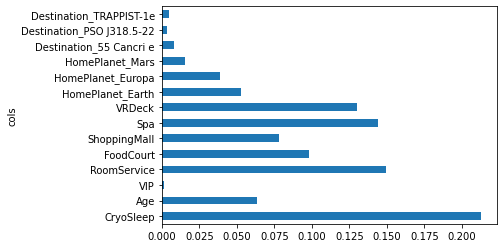

In [140]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=125, oob_score=True).fit(inputs, labels)
pd.DataFrame(dict(cols=inputs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh', legend=False)

We can see that these features still do not register as being very important. It was worth a try though! 

We can try one last submission, this time considering two of the less important columns we excluded last time -- HomePlanet and Age.

In [144]:
inputs, labels = preprocess_df(df, ignore_cols=['VIP', 'Destination'])
rf = RandomForestClassifier(n_estimators=200, min_samples_split=125).fit(inputs, labels)

test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test_inputs, _ = preprocess_df(test_df, is_test=True, ignore_cols=['VIP', 'Destination'])

make_submission(rf, test_inputs, test_df)

We acheived an accuracy of 79.2%, quite a bit lower than our previous attempts. I think it's best that we stick with the original categories we've picked out. 

I think that should wrap up our tuning of a random forest for today. We could continue to experiment and make small changes but our model peformes well enough to put us in the top 40% of kaggle competitors, which is not an exceptional result but I think is a good one given we've taken the simple approach of using a random forest rather than something a bit more involved like gradient boosting.